In [131]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')

In [464]:
data = pd.read_excel("Flight_Fare.xlsx")
original_data = data.copy()  # Backup for future safety

X = data.drop('Price', axis=1)
y = data['Price']
X_train = original_data.drop('Price', axis=1).copy()
y_train = original_data['Price'].copy()
data

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,9/04/2019,Kolkata,Banglore,CCU → BLR,19:55,22:25,2h 30m,non-stop,No info,4107
10679,Air India,27/04/2019,Kolkata,Banglore,CCU → BLR,20:45,23:20,2h 35m,non-stop,No info,4145
10680,Jet Airways,27/04/2019,Banglore,Delhi,BLR → DEL,08:20,11:20,3h,non-stop,No info,7229
10681,Vistara,01/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,12648


In [465]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [466]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [467]:
data.dropna(subset=['Route'], inplace=True)  # drop the 1 missing route row
data['Total_Stops'].fillna('1 stop', inplace=True)  # fill missing stops logically, if it makes sense

Airline
Jet Airways                          3849
IndiGo                               2053
Air India                            1751
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: count, dtype: int64


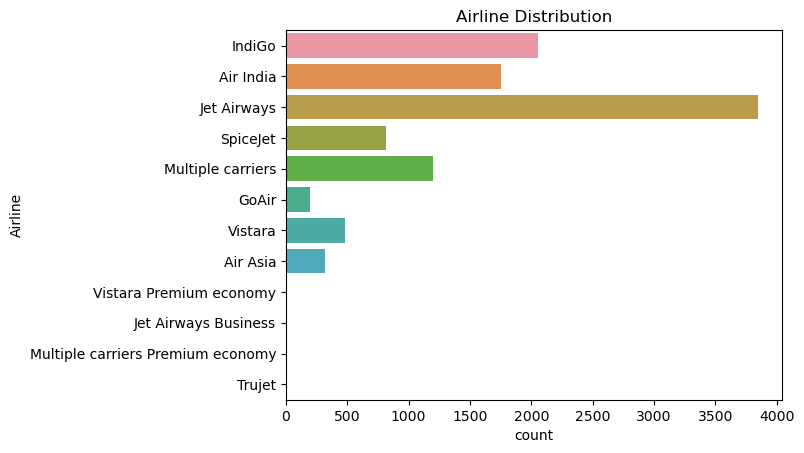

In [468]:
print(data['Airline'].value_counts())
sns.countplot(y='Airline', data=data)
plt.title("Airline Distribution")
plt.show()

In [469]:
# Define threshold
rare_airlines = data['Airline'].value_counts()[data['Airline'].value_counts() < 50].index
# Replace them with "Other"
data['Airline'] = data['Airline'].replace(rare_airlines, 'Other')
print(data['Airline'].value_counts())

Airline
Jet Airways          3849
IndiGo               2053
Air India            1751
Multiple carriers    1196
SpiceJet              818
Vistara               479
Air Asia              319
GoAir                 194
Other                  23
Name: count, dtype: int64


In [470]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10682 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10682 non-null  object
 1   Date_of_Journey  10682 non-null  object
 2   Source           10682 non-null  object
 3   Destination      10682 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10682 non-null  object
 6   Arrival_Time     10682 non-null  object
 7   Duration         10682 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10682 non-null  object
 10  Price            10682 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 1001.4+ KB


In [471]:
data.shape

(10682, 11)

In [472]:
# Convert Date_of_Journey to datetime type
data['Date_of_Journey'] = pd.to_datetime(data['Date_of_Journey'], format='%d/%m/%Y')
data['Journey_day'] = data['Date_of_Journey'].dt.day
data['Journey_month'] = data['Date_of_Journey'].dt.month

# Extract hours and minutes from Dep_Time and Arrival_Time
data['Dep_Time'] = pd.to_datetime(data['Dep_Time'])
data['Dep_hour'] = data['Dep_Time'].dt.hour
data['Dep_minute'] = data['Dep_Time'].dt.minute

data['Arrival_Time'] = pd.to_datetime(data['Arrival_Time'], errors='coerce')  # if format issues
data['Arrival_hour'] = data['Arrival_Time'].dt.hour
data['Arrival_minute'] = data['Arrival_Time'].dt.minute

# Process Duration column (like '2h 50m')
def fix_duration(x):
    if 'h' not in x:
        x = '0h ' + x
    if 'm' not in x:
        x = x + ' 0m'
    return x

data['Duration'] = data['Duration'].apply(fix_duration)
data['Duration_hours'] = data['Duration'].str.extract('(\d+)h').astype(int)
data['Duration_mins'] = data['Duration'].str.extract('(\d+)m').astype(int)

In [473]:
# Split data
X = data.drop("Price", axis=1)
y = data["Price"]

numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

In [498]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
#Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

#Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Journey_day',
                                                   'Journey_month', 'Dep_hour',
                                                   'Dep_minute', 'Arrival_hour',
                                                   'Arrival_minute',
                                                   'Duration_hours',
                                                   'Duration_mins']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Airline', 'Source',
                                                   'Destination', 'Total_Stops',
                                                   'Additional_Info'])])),
                ('regressor', LinearRegression())])

In [499]:
preds = pipeline.predict(X_test)

In [500]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_lr = mean_absolute_error(y_test, preds)
rmse_lr = np.sqrt(mean_squared_error(y_test, preds))
r2_lr = r2_score(y_test, preds)

print("Linear Regression (with scaling and encoding)")
print("MAE:", mae_lr)
print("RMSE:", rmse_lr)
print("R² Score:", r2_lr)

Linear Regression (with scaling and encoding)
MAE: 1778.4198742795952
RMSE: 2704.422500748426
R² Score: 0.6607976088830343


In [501]:
#DECISION TREE REGRESSOR
from sklearn.tree import DecisionTreeRegressor

# Reuse the same preprocessor from before (scaling for numeric, one-hot for categorical)
# Just swap the regressor in the pipeline

pipeline_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

In [502]:
# Train-test split (reuse if already done)
# X_train, X_test, y_train, y_test

pipeline_dt.fit(X_train, y_train)
preds_dt = pipeline_dt.predict(X_test)

In [503]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#Evaluation
mae_d= mean_absolute_error(y_test, preds_dt)
rmse_d = np.sqrt(mean_squared_error(y_test, preds_dt))
r2_d = r2_score(y_test, preds_dt)

print("Decision Tree Results")
print("MAE:", mae_d)
print("RMSE:", rmse_d)
print("R² Score:", r2_d)

Decision Tree Results
MAE: 671.8846513804399
RMSE: 1805.5981633842555
R² Score: 0.8487999159911602


In [504]:
#Hyperparameter grid
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define parameter distribution to sample from
param_dist = {
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 20),
    'regressor__min_samples_leaf': randint(1, 20),
    'regressor__max_features': ['auto', 'sqrt', 'log2', None]
}

# Create RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_dt, param_distributions=param_dist, 
    n_iter=50, cv=5, verbose=2, random_state=42, n_jobs=-1
)

# Fit it
random_search.fit(X_train, y_train)

# Best parameters
print("Best parameters found:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'regressor__max_depth': 13, 'regressor__max_features': None, 'regressor__min_samples_leaf': 4, 'regressor__min_samples_split': 9}


In [505]:
# Evaluate best estimator on test set
best_model = random_search.best_estimator_
preds_best = best_model.predict(X_test)

mae_dt = mean_absolute_error(y_test, preds_best)
rmse_dt = np.sqrt(mean_squared_error(y_test, preds_best))
r2_dt = r2_score(y_test, preds_best)

print("Decision Tree Results")
print("MAE:", mae_dt)
print("RMSE:", rmse_dt)
print("R² Score:", r2_dt)

Decision Tree Results
MAE: 807.8851194261576
RMSE: 1912.8867203285326
R² Score: 0.8302974656128259


In [482]:
#RANDOM FOREST REGRESSOR 
from sklearn.ensemble import RandomForestRegressor
pipeline_rf_baseline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [483]:
numeric_features = ['Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute', 'Arrival_hour', 'Arrival_minute', 'Duration_hours', 'Duration_mins']
categorical_features = ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info']

In [484]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [485]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [486]:
pipeline_rf.fit(X_train, y_train)
preds = pipeline_rf.predict(X_test)

In [487]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# Evaluate
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R^2 Score: {r2:.4f}")

Mean Absolute Error (MAE): 647.8931
Root Mean Squared Error (RMSE): 1640.3069
R^2 Score: 0.8752


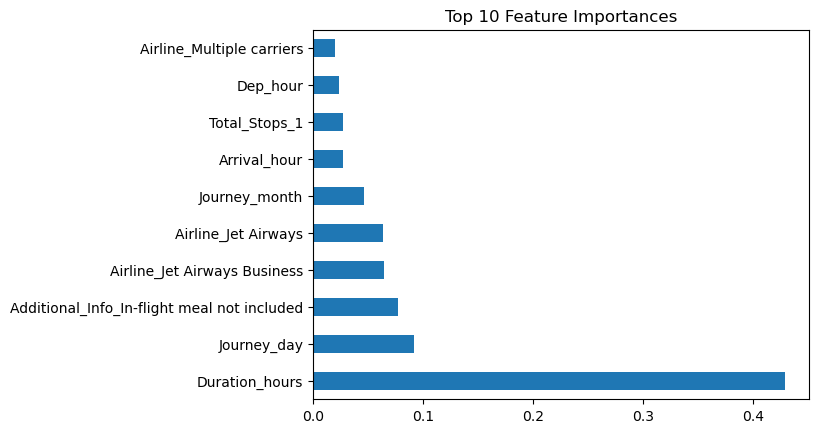

In [418]:
feature_importances = pd.Series(importances, index=all_features)
feature_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

Total_Stops
1    4510
0    2794
2    1203
3      39
Name: count, dtype: int64


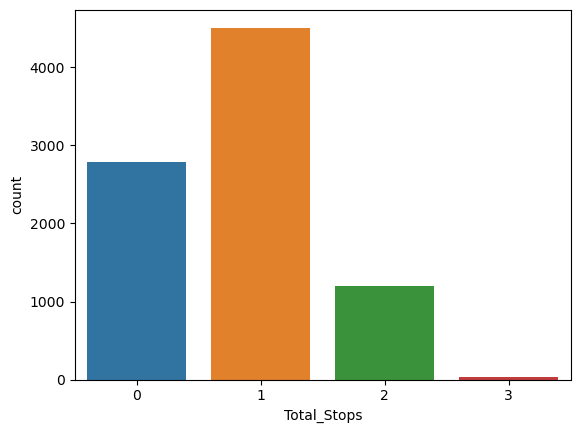

In [419]:
print(X_train['Total_Stops'].value_counts())
sns.countplot(x='Total_Stops', data=X_train)
plt.show()

In [488]:
from sklearn.model_selection import RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['auto', 'sqrt'],
    'regressor__bootstrap': [True, False]
}
random_search = RandomizedSearchCV(pipeline_rf, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
print("Best params:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'auto', 'regressor__max_depth': 30, 'regressor__bootstrap': True}


In [489]:
best_model = random_search.best_estimator_

# Predict on validation set
preds = best_model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 667.7270477789252
RMSE: 1635.0247589722205
R² Score: 0.8760180419593588


In [490]:
from xgboost import XGBRegressor
# Features
numeric_features = ['Journey_day', 'Journey_month', 'Dep_hour', 'Dep_minute',
                    'Arrival_hour', 'Arrival_minute', 'Duration_hours', 'Duration_mins']
categorical_features = ['Airline', 'Source', 'Destination', 'Total_Stops', 'Additional_Info']

In [491]:
# Create column transformer (same as you did before)
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

In [492]:
# Create pipeline with XGBoost
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(random_state=42, n_jobs=-1))
])

In [493]:
# Fit
pipeline_xgb.fit(X_train, y_train)
# Predict
preds_xgb = pipeline_xgb.predict(X_test)

In [494]:
# Evaluate baseline model
mae = mean_absolute_error(y_test, preds_xgb)
rmse = np.sqrt(mean_squared_error(y_test, preds_xgb))
r2 = r2_score(y_test, preds_xgb)

print("XGBoost Regressor Evaluation:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

XGBoost Regressor Evaluation:
MAE: 742.76
RMSE: 1630.59
R²: 0.88


In [495]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_dist = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0]
}

random_search_xgb = RandomizedSearchCV(
    pipeline_xgb,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=42
)

random_search_xgb.fit(X_train, y_train)
print("Best parameters:", random_search.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters: {'regressor__n_estimators': 300, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 2, 'regressor__max_features': 'auto', 'regressor__max_depth': 30, 'regressor__bootstrap': True}


In [496]:
best_model_xgb = random_search_xgb.best_estimator_
best_preds_xgb = best_model_xgb.predict(X_test)

# Evaluate best model
mae_best = mean_absolute_error(y_test, best_preds_xgb)
rmse_best = np.sqrt(mean_squared_error(y_test, best_preds_xgb))
r2_best = r2_score(y_test, best_preds_xgb)

print("\nTuned XGBoost Regressor Evaluation:")
print(f"Best Params: {random_search_xgb.best_params_}")
print(f"MAE: {mae_best:.2f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"R²: {r2_best:.2f}")


Tuned XGBoost Regressor Evaluation:
Best Params: {'regressor__subsample': 0.8, 'regressor__n_estimators': 300, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.05, 'regressor__colsample_bytree': 0.6}
MAE: 646.80
RMSE: 1409.13
R²: 0.91


In [506]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_dt, mae, mae_best],
    'RMSE': [rmse_lr, rmse_dt, rmse, rmse_best],
    'R2 Score': [r2_lr, r2_dt, r2, r2_best]
})
print(results)


               Model          MAE         RMSE  R2 Score
0  Linear Regression  1778.419874  2704.422501  0.660798
1      Decision Tree   807.885119  1912.886720  0.830297
2      Random Forest   742.763743  1630.588056  0.876690
3            XGBoost   646.798696  1409.132931  0.907910


In [511]:
import joblib
# Save the entire pipeline to a file
joblib.dump(pipeline_xgb, 'xgb_flight_fare_pipeline.pkl')

['xgb_flight_fare_pipeline.pkl']

In [512]:
# To load it again later
loaded_model = joblib.load('xgb_flight_fare_pipeline.pkl')